In [1]:
# Installation of the Packages to be used in the sequence.
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")


In [2]:
# In the following, we are going to analyze the data(both monthly and daily) about the gas prices in USA between 1997 and 2020.
# After generating some insights, we are going to find an adequate predictive model by using metrics, correlation plots and other tools.
gas = pd.read_csv('daily_gas_prices.csv')

In [3]:
# General information about the dataset. First of all, we see that dates are stored as object-type and therefore 
# we will need to turn them into date-time objects for visualization purposes.
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5953 entries, 0 to 5952
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5953 non-null   object 
 1   Price   5952 non-null   float64
dtypes: float64(1), object(1)
memory usage: 93.1+ KB


In [4]:
# We also see that the observations of Gas Price have as a starting date the 7th of July 1997 and that 
# there is no information for all the days included in the time span under examination.
gas.head()

,Date,Price
0,1997-01-07,3.82
1,1997-01-08,3.80
2,1997-01-09,3.61
3,1997-01-10,3.92
4,1997-01-13,4.00


In [5]:
#The ending date that a gas price was recorded is the 1st of September in 2020.
gas.tail()

,Date,Price
5948,2020-08-26,2.52
5949,2020-08-27,2.52
5950,2020-08-28,2.46
5951,2020-08-31,2.30
5952,2020-09-01,2.22


In [6]:
gas.describe()

,Price
count,5952.000000
mean,4.184644
std,2.190361
min,1.050000
25%,2.650000
50%,3.530000
75%,5.240000
max,18.480000


In [7]:
# We now convert the strings indicating dates into a datetime object
dates = list()
for i in range(len(gas)):
    dates.append(dt.strptime(gas.loc[i,'Date'],'%Y-%m-%d'))

In [8]:
# We create an additional column including dates in the desirable Datetime format
gas['Date1'] = dates
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5953 entries, 0 to 5952
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5953 non-null   object        
 1   Price   5952 non-null   float64       
 2   Date1   5953 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 139.6+ KB


In [9]:
# Moreover, we check for nan values in the dataset under consideration
gas.isna().sum()

Date     0
Price    1
Date1    0
dtype: int64

In [10]:
# As we have only one missing value, we decide to just leave it out of the dataset
gas = gas.dropna().reset_index()

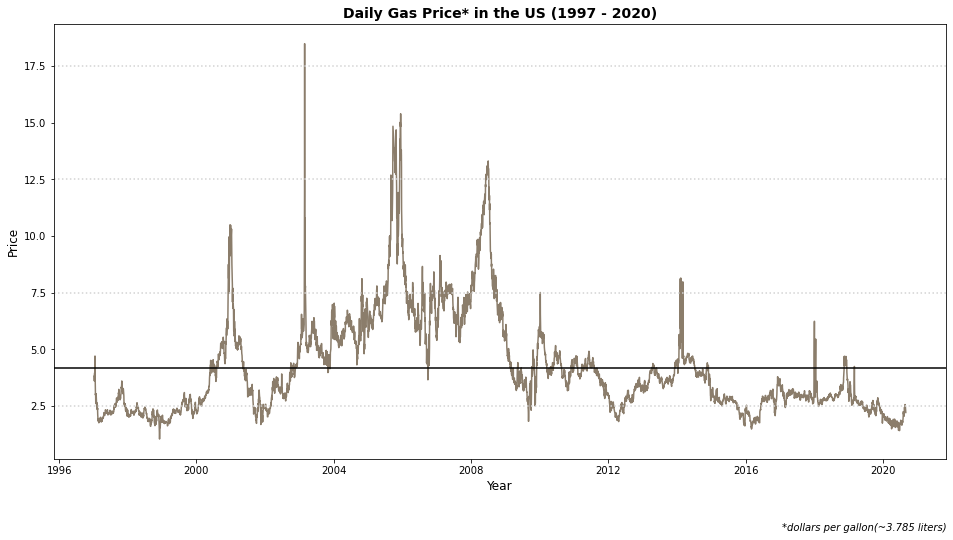

In [11]:
# Now, we are ready to plot the data at hand in order to start creating some first insights. From the plot below, we see that 
# our time series is not stationary, i.e the average price is changing along time, fact that it can be seen by the tendency of the 
# plotted line not to return to the average('black line') with a clear pattern.
fig,ax = plt.subplots(figsize = [16,8])

ax.plot(gas['Date1'], gas['Price'], color = '#8B7D6B')
ax.axhline(y = np.mean(gas['Price']), color = 'black', linestyle = '-')
ax.axhline(y = 2.5, color = 'lightgrey', linestyle = 'dotted')
ax.axhline(y = 7.5, color = 'lightgrey', linestyle = 'dotted')
ax.axhline(y = 12.5, color = 'lightgrey', linestyle = 'dotted')
ax.axhline(y = 17.5, color = 'lightgrey', linestyle = 'dotted')
ax.set_title('Daily Gas Price* in the US (1997 - 2020)', fontweight = 'bold', fontsize = 14)
ax.set_xlabel('Year', fontsize = 12)
ax.set_ylabel('Price', fontsize = 12)
fig.text(x = 0.757 , y = 0, s = '*dollars per gallon(~3.785 liters)', style = 'italic')
plt.show()

In [12]:
# Search for monthly patterns in the Gas Price. We first create a Month column, and we then turn it into a (ordinal)factor.
months = []
for i in range(len(gas)):
    months.append(gas.loc[i,'Date1'].month)

Year = []
for i in range(len(gas)):
    Year.append(gas.loc[i,'Date1'].year)
    
gas['Month'] = months
gas['Month'] = gas['Month'].astype('category')
gas['Year'] = Year
gas['Year'] = gas['Year'].astype('category')

In [13]:
# Now, we get all the descriptive statistics for the Gas Price per month
stats_per_month = gas.groupby('Month')["Price"].describe()
stats_per_month

,count,mean,std,min,25%,50%,75%,max
Month,,,,,,,,
1,487.0,4.384066,2.108656,1.73,2.5850,3.580,5.8300,10.31
2,462.0,4.189589,2.266741,1.62,2.4450,3.205,5.7250,18.48
3,528.0,3.995152,2.038485,1.49,2.3275,3.535,5.2225,9.86
4,499.0,4.107916,2.145082,1.50,2.5250,3.460,5.2450,10.95
5,509.0,4.174931,2.174958,1.56,2.6000,3.730,4.8200,11.85
6,513.0,4.278460,2.382576,1.42,2.5000,3.740,5.1700,13.19
7,508.0,4.047283,2.124912,1.66,2.7900,3.230,4.7200,13.31
8,530.0,4.049698,1.981038,1.61,2.7600,3.200,4.7950,12.69
9,467.0,3.979443,1.970174,1.71,2.7500,3.460,4.6150,14.84


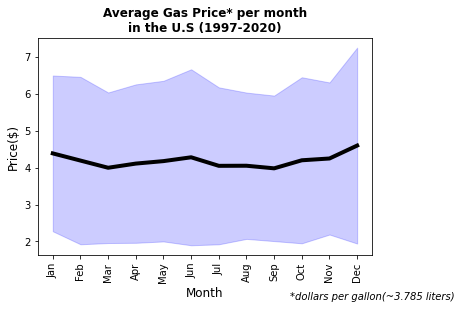

In [14]:
# Lets also visualise. We observe that on average the month with the most expensive gas prices is December. In opposite,
# the month with the least expensive gas prices is September.

fig, ax = plt.subplots()

ax.plot(stats_per_month.index, stats_per_month['mean'], color = 'black', linewidth = 4)
#ax.axhline(y = 4, color = 'lightgrey', linestyle = 'dotted')
#ax.axhline(y = 4.1, color = 'lightgrey', linestyle = 'dotted')
#ax.axhline(y = 4.2, color = 'lightgrey', linestyle = 'dotted')
#ax.axhline(y = 4.3, color = 'lightgrey', linestyle = 'dotted')
#ax.axhline(y = 4.4, color = 'lightgrey', linestyle = 'dotted')
#ax.axhline(y = 4.5, color = 'lightgrey', linestyle = 'dotted')
#ax.axhline(y = 4.6, color = 'lightgrey', linestyle = 'dotted')
ax.set_xlabel('Month', fontsize = 12)
ax.set_ylabel('Price($)', fontsize = 12)
ax.set_title('Average Gas Price* per month\nin the U.S (1997-2020)', fontweight = 'bold', fontsize = 12)
ax.set_xticks(range(1,13))
ax.set_xticklabels(labels = ['Jan','Feb',"Mar",'Apr',"May","Jun","Jul",'Aug',"Sep","Oct","Nov","Dec"], rotation = 90)
fig.text(x = 0.71 , y = -0.03, s = '*dollars per gallon(~3.785 liters)', style = 'italic')

price_std11 = stats_per_month['mean'] + stats_per_month['std']
price_std22 = stats_per_month['mean'] - stats_per_month['std']
ax.fill_between(stats_per_month.index, price_std22, price_std11,alpha = 0.2, color = 'blue')

plt.show()


In [15]:
# Now, we get all the descriptive statistics for the Gas Price per year.
# From the line graph 
stats_per_year = gas.groupby('Year')["Price"].describe()
stats_per_year

,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
1997,249.0,2.489839,0.513092,1.77,2.1600,2.320,2.8200,4.71
1998,251.0,2.088367,0.237452,1.05,1.9500,2.110,2.2350,2.65
1999,250.0,2.274120,0.354632,1.63,2.0300,2.265,2.5200,3.10
2000,249.0,4.311486,1.723166,2.16,2.9200,4.210,4.9200,10.49
2001,250.0,3.959120,1.802864,1.69,2.4625,3.300,5.1600,10.31
2002,250.0,3.375600,0.711617,2.03,2.9400,3.325,3.8525,5.31
2003,250.0,5.471160,1.279748,3.98,4.8400,5.200,5.8325,18.48
2004,249.0,5.892892,0.620971,4.32,5.4300,5.820,6.2600,8.12
2005,241.0,8.685892,2.644639,5.53,6.6300,7.450,10.6800,15.39


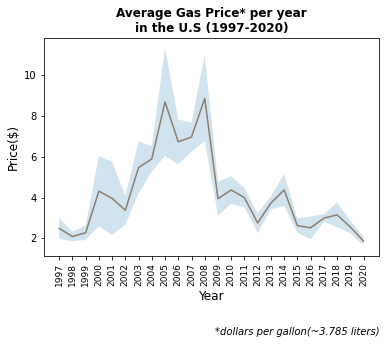

In [16]:
# It can be easily seen that in 2002 the gas price started a steep rise until 2005 and after a short decrease in 2006,
# the Gas price in US in 2008 witnessed its highest average value between 1997 and 2020.
fig, ax = plt.subplots()

ax.plot(stats_per_year.index, stats_per_year['mean'], color = '#8B7D6B')
#ax.axhline(y = 4, color = 'lightgrey', linestyle = 'dotted')
#ax.axhline(y = 4.1, color = 'lightgrey', linestyle = 'dotted')
#ax.axhline(y = 4.2, color = 'lightgrey', linestyle = 'dotted')
#ax.axhline(y = 4.3, color = 'lightgrey', linestyle = 'dotted')
#ax.axhline(y = 4.4, color = 'lightgrey', linestyle = 'dotted')
#ax.axhline(y = 4.5, color = 'lightgrey', linestyle = 'dotted')
#ax.axhline(y = 4.6, color = 'lightgrey', linestyle = 'dotted')
ax.set_xlabel('Year', fontsize = 12)
ax.set_ylabel('Price($)', fontsize = 12)
ax.set_title('Average Gas Price* per year\nin the U.S (1997-2020)', fontweight = 'bold', fontsize = 12)
ax.set_xticks(range(1997,2021))
ax.set_xticklabels(rotation = 90, labels = range(1997,2021), fontsize = 9)
fig.text(x = 0.52 , y = -0.15, s = '*dollars per gallon(~3.785 liters)', style = 'italic')

price_std1 = stats_per_year['mean'] + stats_per_year['std']
price_std2 = stats_per_year['mean'] - stats_per_year['std']
ax.fill_between(stats_per_year.index, price_std2, price_std1,alpha = 0.2)
plt.show()


In [ ]:
# Now we aim to create a predictive ARIMA model for the Gas Prices in the US. 
# To this end, we need to determine the order of Autoregression(AR),i.e how many past values
# will be used for predicting the 'present' value and the Moving Average(MA) order. For both 
# orders we are going to consult Autocorrelation and Partial Autocorrelation plots in the following.

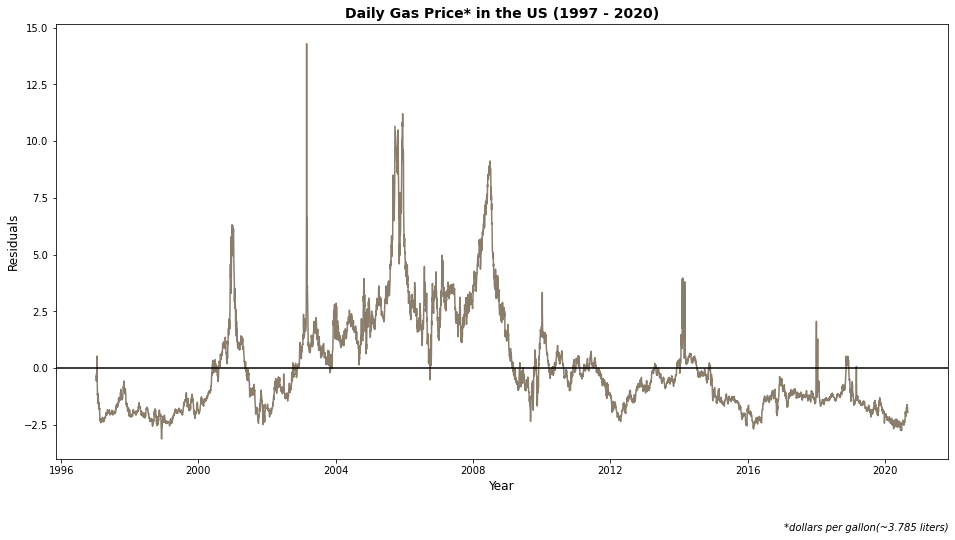

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 5952
Model:                          ARIMA   Log Likelihood              -13111.785
Date:                Fri, 09 Sep 2022   AIC                          26227.570
Time:                        13:10:13   BIC                          26240.953
Sample:                             0   HQIC                         26232.220
                               - 5952                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1846      0.040    105.330      0.000       4.107       4.263
sigma2         4.7968      0.076     63.281      0.000       4.648       4.945
===================================================================================
Ljung-Box (L1) (Q):                5865.43   Jarque-Bera (JB):              5211.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             1.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

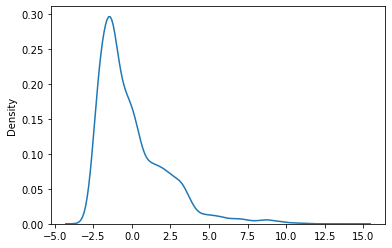

In [17]:
# We fit a model of the form Y_t = b_0 + err_t. Hence the residuals here are just the difference between each price and the
# mean price and therefore there is no impact on the non-stationary behaviour of the series. 
# Moreover, the ratio rss/tss indicating the ratio of variance in the data that has remained unexplained by the model is 
# 1,i.e no variance explained. We also plot the approximate density of residuals using the kernel density estimation approach. 
sample = gas['Price']
sample.index = gas['Date1']
model_trivial = ARIMA(sample, order = (0,0,0))
model_trivial_fit = model_trivial.fit()
residuals_trivial = model_trivial_fit.resid


fig,ax = plt.subplots(figsize = [16,8])

ax.plot(residuals_trivial.index, residuals_trivial, color = '#8B7D6B')
ax.axhline(y = np.mean(residuals_trivial), color = 'black', linestyle = '-')
#ax.axhline(y = 2.5, color = 'lightgrey', linestyle = 'dotted')
#ax.axhline(y = 7.5, color = 'lightgrey', linestyle = 'dotted')
#ax.axhline(y = 12.5, color = 'lightgrey', linestyle = 'dotted')
#ax.axhline(y = 17.5, color = 'lightgrey', linestyle = 'dotted')
ax.set_title('Daily Gas Price* in the US (1997 - 2020)', fontweight = 'bold', fontsize = 14)
ax.set_xlabel('Year', fontsize = 12)
ax.set_ylabel('Residuals', fontsize = 12)
fig.text(x = 0.757 , y = 0, s = '*dollars per gallon(~3.785 liters)', style = 'italic')
plt.show()

sns.kdeplot(residuals_trivial)
model_trivial_fit.summary()



In [18]:
# For checking Stationarity of the given Time Series we can employ the Augmented Dickey-Fuller test as follows
from statsmodels.tsa.stattools import adfuller
alpha = 0.05# Statistical Significance
stationary_test = adfuller(gas['Price'])
if stationary_test[1]<= alpha:
    print('pvalue:',stationary_test[1],',Reject Null Hypothesis-Series is (probably)Stationary.')
else:
    print('pvalue:',stationary_test[1],',Cannot Reject Null Hypothesis - Series is (probably)non-Stationary.')


pvalue: 0.040579317774113235 ,Reject Null Hypothesis-Series is (probably)Stationary.


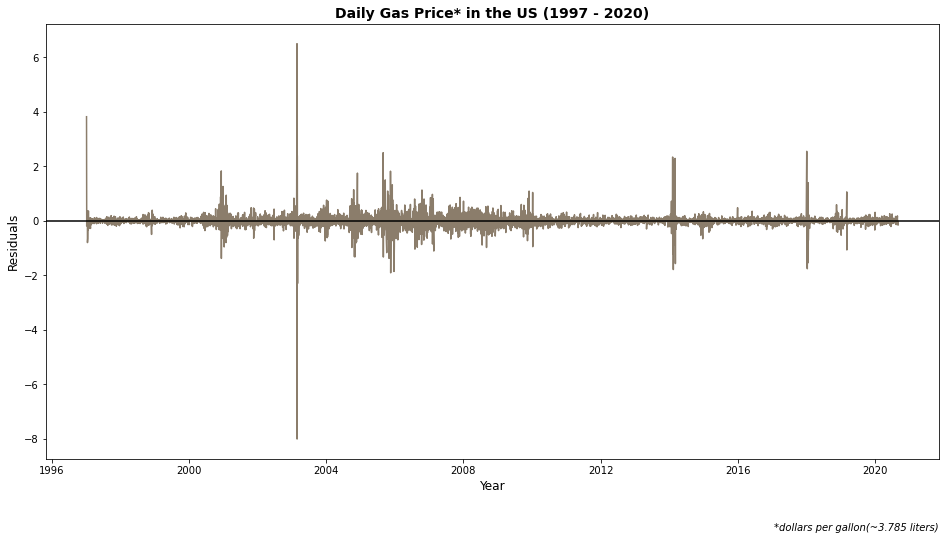

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 5952
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -605.492
Date:                Fri, 09 Sep 2022   AIC                           1212.985
Time:                        13:10:22   BIC                           1219.676
Sample:                             0   HQIC                          1215.309
                               - 5952                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0718      0.000    586.102      0.000       0.072       0.072
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):          12990961.11
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                       231.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

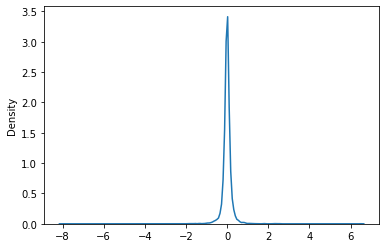

In [19]:
# Now, if we set the differencing order to 1 we get a way more stationary plot for the residual series. Here the model that is 
# fitted has the form y_t =  err_t(without a constant, since the mean of the differences is becoming really small
# and in turn si ommited by the model), where y_t = Y_t - Y_(t-1) and Y_t is the gas price at the moment t.
model = ARIMA(sample, order = (0,1,0))
model_fit = model.fit()
residuals = model_fit.resid


fig,ax = plt.subplots(figsize = [16,8])

ax.plot(residuals.index, residuals, color = '#8B7D6B')
ax.axhline(y = np.mean(residuals), color = 'black', linestyle = '-')
#ax.axhline(y = 2.5, color = 'lightgrey', linestyle = 'dotted')
#ax.axhline(y = 7.5, color = 'lightgrey', linestyle = 'dotted')
#ax.axhline(y = 12.5, color = 'lightgrey', linestyle = 'dotted')
#ax.axhline(y = 17.5, color = 'lightgrey', linestyle = 'dotted')
ax.set_title('Daily Gas Price* in the US (1997 - 2020)', fontweight = 'bold', fontsize = 14)
ax.set_xlabel('Year', fontsize = 12)
ax.set_ylabel('Residuals', fontsize = 12)
fig.text(x = 0.757 , y = 0, s = '*dollars per gallon(~3.785 liters)', style = 'italic')
plt.show()

sns.kdeplot(residuals)
model_fit.summary()



In [20]:
# If we check Stationarity of the residuals(i.e the first order differenced time-series) 
# by using the Augmented Dickey-Fuller test, we get the following. So, the p-value is by far smaller than 
# the one given by applying the test to the original Time-Series. Hence, this fact combined with the 
# clearly more stationary plot of the residuals, signifies that one order differencing may be helpful towards
# predicting future gas prices.

alpha = 0.05# Statistical Significance
stationary_test = adfuller(residuals)
if stationary_test[1]<= alpha:
    print('pvalue:',stationary_test[1],',Reject Null Hypothesis-Series is (probably)Stationary.')
else:
    print('pvalue:',stationary_test[1],',Cannot Reject Null Hypothesis - Series is (probably)non-Stationary.')

pvalue: 1.4788381044203514e-28 ,Reject Null Hypothesis-Series is (probably)Stationary.


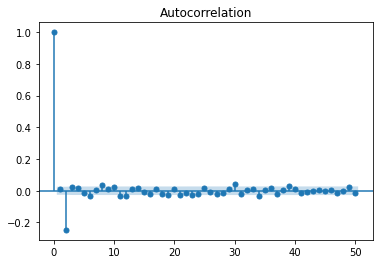

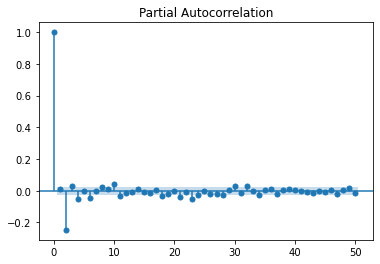

In [21]:
# We move forward into finding the most appropriate AR(AutoRegressive) and MA(Moving Average) parameters for the 
# ARIMA model that we are going to use.
plot_acf(residuals, lags = 50, alpha = 0.05)
plot_pacf(residuals, lags = 50, alpha = 0.05)
plt.show()

In [22]:
# As both plots are showing significant spike at lag 2, we first decide to fit an ARIMA model of 
# the form y_t = b_1*y_(t-1) + b_2*y_(t-2) + err_t, where y_t as previously or in other words an ARIMA(2,1,0).
# This is an improvement of previous model, as AIC, BIC and HQIC have smaller values while there is a decrease in 
# the variance of the errors as well. Also, we see that the coefficients are statisticallt significant and away from 1
# indicating that no further differencing is needed.

model_210 = ARIMA(sample, order  = (2,1,0))
model_210_fit = model_210.fit()
resid_210 = model_210_fit.resid

model_210_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 5952
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -406.951
Date:                Fri, 09 Sep 2022   AIC                            819.902
Time:                        13:10:35   BIC                            839.976
Sample:                             0   HQIC                           826.876
                               - 5952                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0110      0.002      5.294      0.000       0.007       0.015
ar.L2         -0.2540      0.004    -67.964      0.000      -0.261      -0.247
sigma2         0.0671      0.000    385.946      0.000       0.067       0.067
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):           8658203.53
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                             1.50
Prob(H) (two-sided):                  0.00   Kurtosis:                       189.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

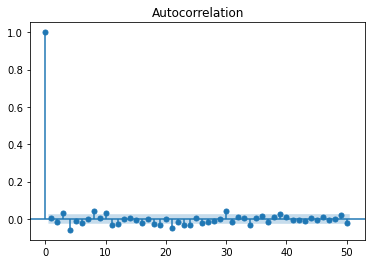

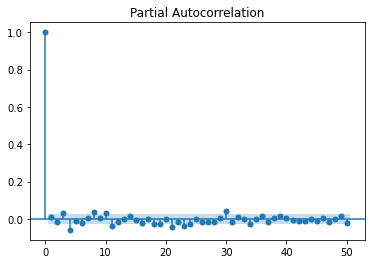

In [23]:
# Now, from the ACF and PACF plots we see no such significant spikes at any lag as in the previous model, indicating
# that there is no so much inforamtion at previous lags for predicting a future value.
plot_acf(resid_210, lags = 50, alpha = 0.05)
plot_pacf(resid_210, lags = 50, alpha = 0.05)
plt.show()

In [24]:
# Now we fit an ARIMA model of 
# the form y_t = -b_1*e_(t-1) - b_2*e_(t-2) + err_t, where y_t as previously or in other words an ARIMA(0,1,2).
# From the summary of the model we see that the metrics AIC, BIC and HQIC are smaller than for the ARIMA(2,1,0)
# signifying an improvement of the model. That, the parameters coefficients are statistically significant and away from 1
# indicate the invertibility of the model and in turn greater capability in estimating the errors in the orignal series. 

model_012 = ARIMA(sample, order  = (0,1,2))
model_012_fit = model_012.fit()
resid_012 = model_012_fit.resid

model_012_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 5952
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -395.032
Date:                Fri, 09 Sep 2022   AIC                            796.063
Time:                        13:10:42   BIC                            816.137
Sample:                             0   HQIC                           803.037
                               - 5952                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0245      0.002     10.023      0.000       0.020       0.029
ma.L2         -0.2678      0.004    -60.831      0.000      -0.276      -0.259
sigma2         0.0669      0.000    328.886      0.000       0.066       0.067
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):           8400023.52
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                             1.54
Prob(H) (two-sided):                  0.00   Kurtosis:                       187.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

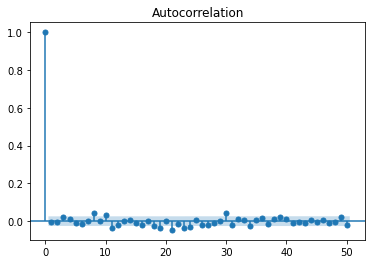

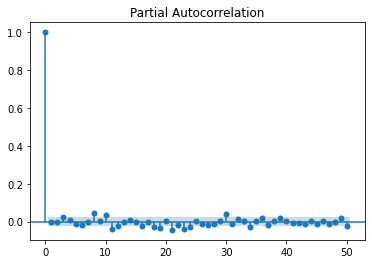

In [25]:
# Here the spikes of the lags are even less significant than that of ARIMA model (2,1,0), indicating 
# again a better fit of this model to the given time series.
plot_acf(resid_012, lags = 50, alpha = 0.05)
plot_pacf(resid_012, lags = 50, alpha = 0.05)
plt.show()

In [26]:
# Now, for these two models ARIMA(2,1,0) and ARIMA(0,1,2) we are going to perform a train-test validation and 
# calculating R-squared metric. The process goes as follows.
# The results indicate a marginally better efficiency of the ARIMA(2,1,0) model, however as the rest of the metrics
# provided by the models summary are in favour of ARIMA(0,1,2) we would still prefer to continue with this model.
test = sample[sample.index > '2020'].values
train = sample[sample.index < '2020'].values
predictions = []
for i in range(len(test)):
    model = ARIMA(train, order = (2,1,0))
    model_fit = model.fit()
    predictions.append(model_fit.forecast())
    train = np.append(train,test[i])
    
res = [test[i]-predictions[i] for i in range(len(test))]
m = np.mean(test)
rss = sum([x**2 for x in res])
tss = sum([(y - m)**2 for y in test])
r_squared = 1 - rss/tss

predictions1 = []
for i in range(len(test)):
    model = ARIMA(train, order = (0,1,2))
    model_fit = model.fit()
    predictions1.append(model_fit.forecast())
    train = np.append(train,test[i])
    
res1 = [test[i]-predictions1[i] for i in range(len(test))]
m1 = np.mean(test)
rss1 = sum([x**2 for x in res1])
tss1 = sum([(y - m1)**2 for y in test])
r_squared1 = 1 - rss1/tss1

pd.DataFrame({'R^2(2,1,0)': r_squared, 'R^2(0,1,2)' :r_squared1})

,"R^2(2,1,0)","R^2(0,1,2)"
0,0.855293,0.850743


In [200]:
# Another metric used to mesaure the accuracy of an ARIMA model is the Mean Absolute Percentage Error(MAPE) and 
# is calculated as follows. As with R_squared, the model ARIMA(2,1,0) is performing slightly better than the ARIMA(0,1,2)
# using the MAPE metric.

mape = np.sum(np.abs(res/test)) / len(test)
mape1 = np.sum(np.abs(res1/test)) / len(test)

{'MAPE ARIMA(2,1,0)': mape, 'MAPE ARIMA(0,1,2)' : mape1}

{'MAPE ARIMA(2,1,0)': 6.243159581493492,
 'MAPE ARIMA(0,1,2)': 6.320661227820467}

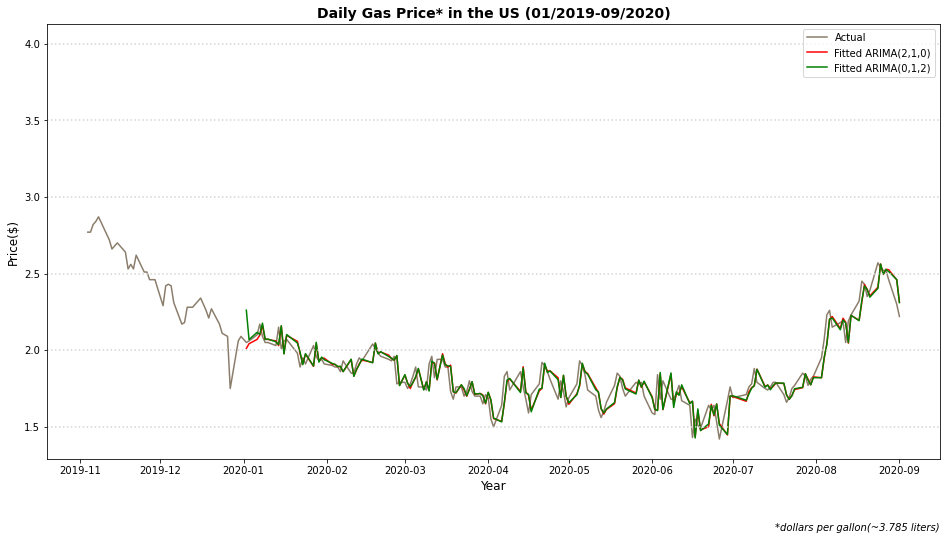

In [27]:
# However, we continue the investigation of these two models, by plotting their resprctive predictions for the year of 2020.
# So, in the plot below, we use the 'red' colour to present the predictions obtained by the ARIMA(2,1,0) model and
# 'green' colour for the those obtained by the ARIMA(0,1,2).
# It can be seen that both models predictions are really close to the actual values signifying high model accuracy. But, 
# the possibility of data overfitting exists as well.
fig,ax = plt.subplots(figsize = [16,8])

ax.plot(sample.index[sample.index>'2019-11-03'], sample.loc[sample.index>'2019-11-03'], color = '#8B7D6B', label = 'Actual')
ax.plot(sample.index[sample.index>'2020'], predictions, color = 'red', label = 'Fitted ARIMA(2,1,0)')
ax.plot(sample.index[sample.index>'2020'], predictions1, color = 'green', label = 'Fitted ARIMA(0,1,2)')
ax.axhline(y = 4, color = 'lightgrey', linestyle = 'dotted')
ax.axhline(y = 3.5, color = 'lightgrey', linestyle = 'dotted')
ax.axhline(y = 3, color = 'lightgrey', linestyle = 'dotted')
ax.axhline(y = 2.5, color = 'lightgrey', linestyle = 'dotted')
ax.axhline(y = 2, color = 'lightgrey', linestyle = 'dotted')
ax.axhline(y = 1.5, color = 'lightgrey', linestyle = 'dotted')
#ax.axhline(y = 17.5, color = 'lightgrey', linestyle = 'dotted')
ax.set_title('Daily Gas Price* in the US (01/2019-09/2020)', fontweight = 'bold', fontsize = 14)
ax.set_xlabel('Year', fontsize = 12)
ax.set_ylabel('Price($)', fontsize = 12)
fig.text(x = 0.757 , y = 0, s = '*dollars per gallon(~3.785 liters)', style = 'italic')
plt.legend(loc="upper right")
plt.show()

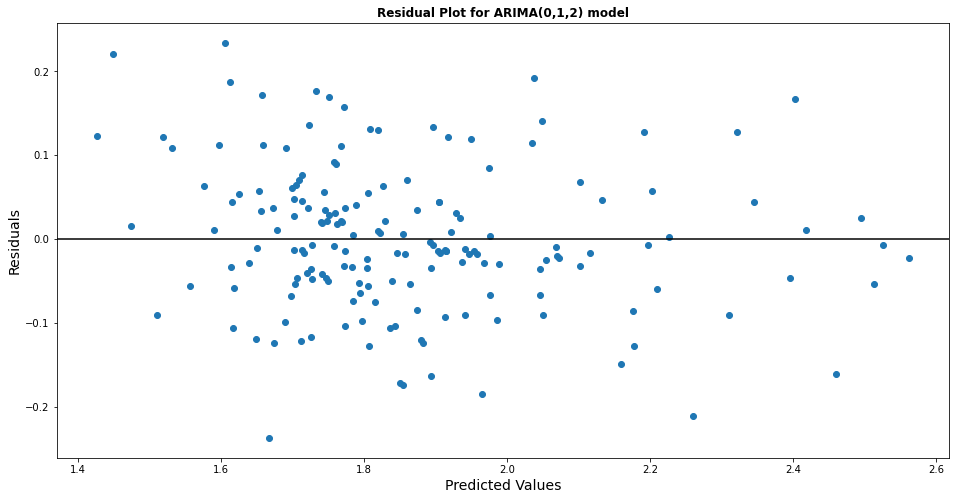

In [28]:
# The next step forward is to check the linear regression conditions for the residuals. We start, by checking whether the residuals of 
# the ARIMA(0,1,2) satisfy homoscedasticity. From the following residual plot we see that there is a slight decrease in the 
# variance of the residuals along the mean('black line') indicating homoscedastic residuals. Moreover by the Autocorrelation plot
# above we see that the residuals are mostly uncorrelated with statistical significance 5%, hence independent. So, the condition 
# independent and identically distributed residuals is probably satisfied with statistical significance 95%.
fig,ax = plt.subplots(figsize = [16,8])

ax.scatter(predictions1,res1)
ax.axhline(y = np.mean(res1),  color = 'black', linestyle = '-')
#ax.axhline(y = 2.5, color = 'lightgrey', linestyle = 'dotted')
#ax.axhline(y = 7.5, color = 'lightgrey', linestyle = 'dotted')
#ax.axhline(y = 12.5, color = 'lightgrey', linestyle = 'dotted')
#ax.axhline(y = 17.5, color = 'lightgrey', linestyle = 'dotted')
#ax.set_title('Daily Gas Price* in the US (1997 - 2020)', fontweight = 'bold', fontsize = 14)
ax.set_xlabel('Predicted Values', fontsize = 14)
ax.set_ylabel('Residuals', fontsize = 14)
ax.set_title('Residual Plot for ARIMA(0,1,2) model', fontweight = 'bold')
#fig.text(x = 0.757 , y = 0, s = '*dollars per gallon(~3.785 liters)', style = 'italic')
plt.show()


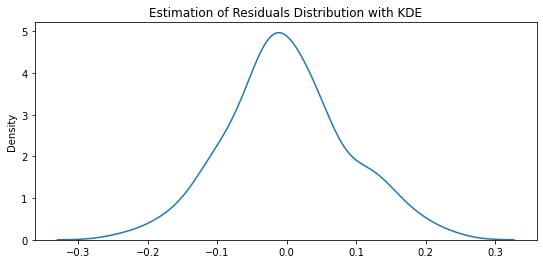

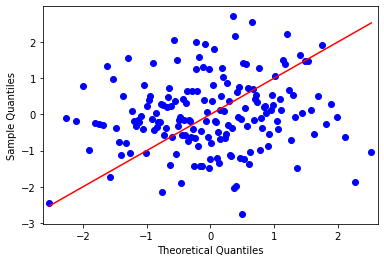

In [29]:
# Now, we embark on checking the normality condition of the residuals. We do this using two methods, fitst we use
# Kernel Distribution Estimation to approximate the distribution of the residuals. Secondly we perform a qqplot to
# check how close to the normal distribution the residuals distribution is.
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
fig, ax = plt.subplots(figsize = (9,4))

res_df = pd.Series(data = res1)
res_df.index = gas.loc[gas["Date1"] > '2020', "Date1"]

#ax.plot(np.array(res))
sns.kdeplot(res_df.values.astype(float)).set(title = 'Estimation of Residuals Distribution with KDE')
res1_standard = (res1 - np.mean(res1))/np.std(res1)
sm.qqplot(np.array(res1_standard), line ='s')# From the qqplot does not follow that the residuals are following normal distribution
# However as the two methods for checking normality are not giving a clear result, we proceed with the Shapiro-Wilk Normality test.

plt.show()

In [30]:
# Hypothesis Testing: Null Hypothesis : The Distribution of the residuals is Gaussian
# We suppose that all observations in the set of residuals are independent and identically distributed(iid)
# To check this hypothesis we deploy Shapiro-Wilk Normality Test with the statistical significance at the usual level of 0.05.
# The test asserts that there is a significant probability that the residuals are cominf from a noraml distribution.
from scipy.stats import shapiro
stat, p = shapiro(res1)
if p <=0.05:
    print('Residuals are probably not following the Normal Distribution as the p-value is:',p)
else:
    print('Residuals are probably following the Normal Distribution as the p-value is:',p)

Residuals are probably following the Normal Distribution as the p-value is: 0.40733352303504944


In [35]:
# An effort to calculate R_squared for different lag order parameters. Too many model fittings for this examination 
# to work smoothly.
"""collect=[]
for i in range(1,3):
    #model1_fit.summary()
    test = series[series.index > '2020'].values
    train = series2.values
    predictions = []
    for j in range(len(test)):
        model = ARIMA(train, order = (i,1,0))
        model_fit = model.fit()
        predictions.append(model_fit.forecast())
        train = np.append(train,test[j])
    res = [test[i]-predictions[i] for i in range(len(test))]
    m = np.mean(test)
    rss = sum([x**2 for x in res])
    tss = sum([(y - m)**2 for y in test])
    r_squared = 1 - rss/tss
    collect.append(r_squared)
pd.DataFrame({'R^2': collect})"""

"collect=[]\nfor i in range(1,3):\n    #model1_fit.summary()\n    test = series[series.index > '2020'].values\n    train = series2.values\n    predictions = []\n    for j in range(len(test)):\n        model = ARIMA(train, order = (i,1,0))\n        model_fit = model.fit()\n        predictions.append(model_fit.forecast())\n        train = np.append(train,test[j])\n    res = [test[i]-predictions[i] for i in range(len(test))]\n    m = np.mean(test)\n    rss = sum([x**2 for x in res])\n    tss = sum([(y - m)**2 for y in test])\n    r_squared = 1 - rss/tss\n    collect.append(r_squared)\npd.DataFrame({'R^2': collect})"

In [36]:
# Average monthly gas prices in US from 01/1997 to 08/2020. We aim to make a prediction for the average 
# gas price for the September of 2020(09-2020)
gas_month = pd.read_csv('monthly_gas_prices.csv')

gas_month.tail()

,Month,Price
279,2020-04,1.74
280,2020-05,1.75
281,2020-06,1.63
282,2020-07,1.77
283,2020-08,2.30


In [37]:
gas_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   284 non-null    object 
 1   Price   284 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.6+ KB


In [38]:
# We once more turn the dates into datetime objects for visualisation purposes.
for i in range(0, len(gas_month)):
    gas_month.loc[i,'Month'] = dt.strptime(gas_month.loc[i,'Month'],'%Y-%m')    

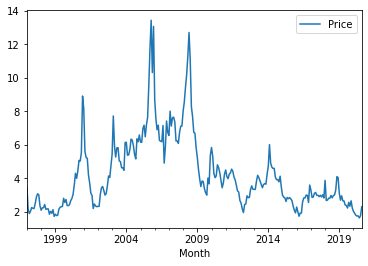

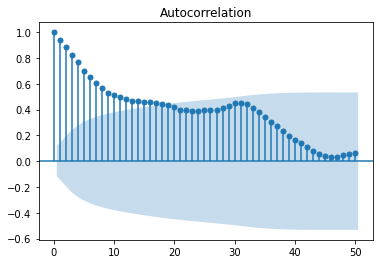

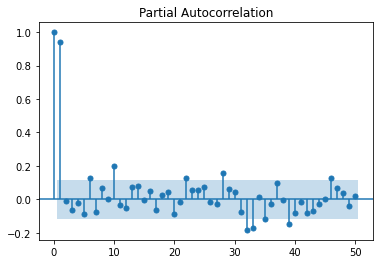

In [39]:
# From the Autocorrealtion and Partial Autocorrelation plot we see that there is a great correlation between y_t and y_(t-1)(lag1)
# In fact in the Autocorrelation plot we see that the inertia of the first lag is trailling off and is becoming statistically
# insignificant at lag 18. However, from the PACF plot we verify that most of the correlation of y_t with earlier lags 
# is indeeed due to its correlation with lag1, as it is evident that there is a rapid decrease after the first lag. But, from
# the PACF plot again we see that there are some larger lags with significant correlation as well, case that we may analyze more
# in the following.
gas_month.index = gas_month['Month']
gas_month = gas_month[['Price']]
gas_month.plot()
plot_acf(gas_month, lags = 50)
plot_pacf(gas_month, lags = 50)

plt.show()

In [40]:
# By the Partial Autocorrelation plot we see that there is a strong correlation at lag 1 and then a sharp decrease
# indicating that only lag 1 could be probably enough for predicting a future value. So lets fit a model of the form 
# y_t = b_1*y_(t-1) + e_t. The summary of the model shows that the lag1 coefficient(b_1) is stat.significant and close to 
# 1, which in turn means that a first order non-seasonal differencing would be preferable instead. 
model_month = sm.tsa.statespace.SARIMAX(gas_month,order = (1,0,0),seasonal_order = (0,0,0,0), trend = 'n')
model_month_fit = model_month.fit()
model_month_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  284
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -317.577
Date:                Fri, 09 Sep 2022   AIC                            639.155
Time:                        13:37:11   BIC                            646.453
Sample:                    01-01-1997   HQIC                           642.081
                         - 08-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9862      0.005    187.616      0.000       0.976       0.996
sigma2         0.5411      0.022     25.110      0.000       0.499       0.583
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):               710.96
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
model_month1 = sm.tsa.statespace.SARIMAX(gas_month,order = (0,1,0),seasonal_order = (0,0,0,0), trend = 'n')
model_month1_fit = model_month1.fit()
model_month1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  284
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -315.793
Date:                Fri, 09 Sep 2022   AIC                            633.585
Time:                        13:37:19   BIC                            637.231
Sample:                    01-01-1997   HQIC                           635.047
                         - 08-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.5455      0.020     26.692      0.000       0.505       0.586
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):               779.24
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

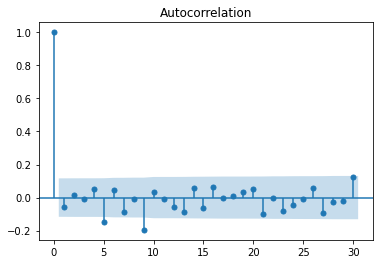

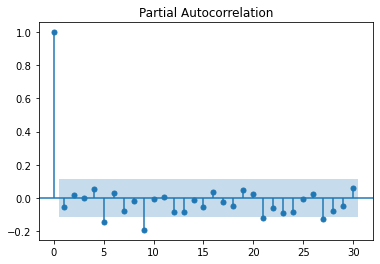

In [42]:
# The following Autocorrelation and Patial Autocorrelation plots show that the most significant spike is at lag9.
# Therefore, with this information in mind we procceed to the next model building.
resid_month1 = model_month1_fit.resid
#print(gas_month[0:14])
#resid_month.plot()
plot_acf(resid_month1, lags = 30)
plot_pacf(resid_month1, lags = 30)
plt.show()

In [43]:
# So, we fit a model of the form y*_t = b_1*y*_(t-9) + e_t, where y*_t = y_t - y_(t-1) and y_t is the original series.
# Based on the metrics AIC, BIC, HQIC this model is better than the previous one, while the variance of the errors has been also
# slightly reduced.
model_month2 = sm.tsa.statespace.SARIMAX(gas_month,order = (0,1,0),seasonal_order = (1,0,0,9), trend = 'n')
model_month2_fit = model_month2.fit()
model_month2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Price   No. Observations:                  284
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 9)   Log Likelihood                -309.200
Date:                           Fri, 09 Sep 2022   AIC                            622.401
Time:                                   13:37:24   BIC                            629.691
Sample:                               01-01-1997   HQIC                           625.324
                                    - 08-01-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L9       -0.2118      0.064     -3.319      0.001      -0.337      -0.087
sigma2         0.5199      0.019     27.377      0.000       0.483       0.557
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               896.61
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

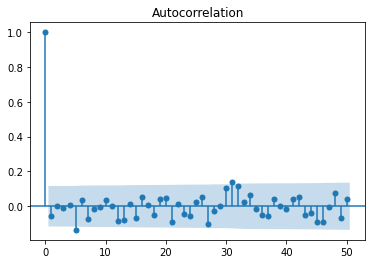

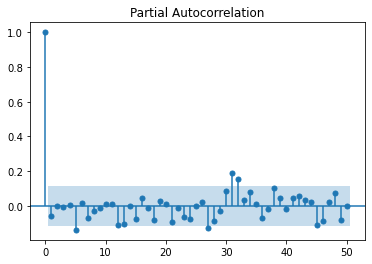

In [44]:
# The Autocorrelation plot below shows that almost all of the autocorreltions have become insignificant, which implies that
# there is no much significant information left for determining a future value.
resid_month2 = model_month2_fit.resid
#print(gas_month[0:14])
#resid_month.plot()
plot_acf(resid_month2, lags = 50)
plot_pacf(resid_month2, lags = 50)
plt.show()

In [48]:
rsquared_list = []

In [53]:
# Even though the amount of data is rather small, we are tempted to train and test our model and finally 
# to find the R-squared metric. But, as we can see in the following as we increase the test data then the R^2 squared is 
# increasing also, 

train_set = gas_month.loc[gas_month.index < '2019',:].values
test_set = gas_month.loc[gas_month.index >= '2019',:].values



predictions2 = []

for i in range(len(test_set)):
    model = sm.tsa.statespace.SARIMAX(train_set,order = (0,1,0),seasonal_order = (1,0,0,9), trend = 'n')
    model_fit = model.fit()
    predictions2.append(model_fit.forecast())
    train_set = np.append(train_set,test_set[i])
    
res2 = [test_set[i]-predictions2[i] for i in range(len(test_set))]
m2 = np.mean(test_set)
rss2 = sum([x**2 for x in res2])
tss2 = sum([(y - m2)**2 for y in test_set])
r_squared2 = 1 - rss2/tss2
rsquared_list = np.append(rsquared_list,r_squared2)




In [54]:
# Here the index of the dataframe indicates the year selected for partitioning the data and it is clear how the accuracy is increased 
# as we have larger test set.
rsquared_df = pd.DataFrame({'R^2(0,1,0)x(1,0,0)_9' :rsquared_list})
rsquared_df.index = [2010,2012,2015,2017,2019]
rsquared_df

,"R^2(0,1,0)x(1,0,0)_9"
2010,0.815580
2012,0.759113
2015,0.532294
2017,0.561078
2019,0.369092


In [55]:
# Using the model under investigation(SARIMA(0,1,0)x(1,0,0)_9) we  will perform two kinds of predictions.
# The first one will use the in-sample values(endog) as earlier but performing it in another fashion,
# while in the second one we will perform a dymamical prediction using the one step ahead predictions that we got from the model. 
# We start by building a model using the gas prices up to the year of 2019.

mod = sm.tsa.statespace.SARIMAX(gas_month.loc[gas_month.index < '2019',:],order = (0,1,0),seasonal_order = (1,0,0,9), trend = 'n')
res_fit = mod.fit(disp=False, maxiter=250)


In [56]:
# We continue by using Kalmars Filtering for determining Log Likelihood with the fitted parameters from the previous step 
mod1 = sm.tsa.statespace.SARIMAX(gas_month,order = (0,1,0),seasonal_order = (1,0,0,9), trend = 'n')
res11 = mod1.filter(res_fit.params)


In [57]:
predict = res11.get_prediction()
predict_ci = predict.conf_int()

In [58]:
predict_dy = res11.get_prediction(dynamic = '2019-01-01')
predict_dy_ci = predict_dy.conf_int()

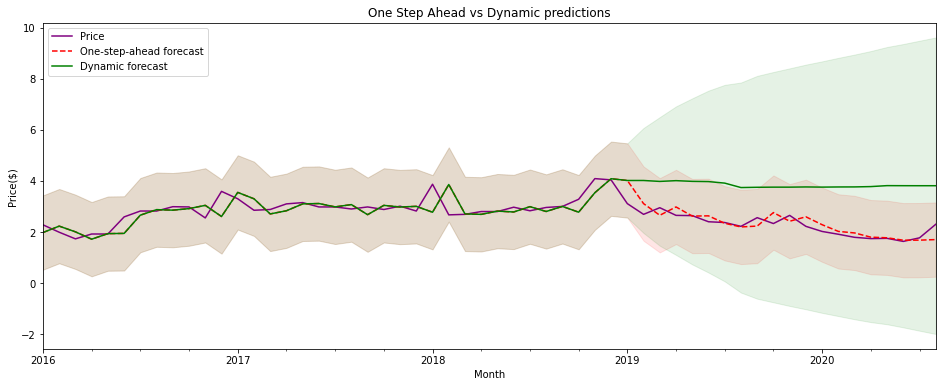

In [59]:
# In the following we can see that the Dynamic Predictions are getting way less accurate once the predicted values 
# up to this point are used for predictions. Also, the variance and hence the insignificance of these predictions is increasing.
# Also, we observe that the one step ahead predictions are quite fine, but there is a pattern of delay, since there are 
# many instances where they follow the actual prices but slightly belated. 
fig, ax = plt.subplots(figsize = (16,6))
ax.set(title = 'One Step Ahead vs Dynamic predictions', ylabel = 'Price($)')

gas_month.loc['2016-01-01':].plot(ax = ax, label = 'Observed', color = 'purple')
predict.predicted_mean.loc['2016-01-01':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc['2016-01-01':]
ax.fill_between(ci.index,ci.iloc[:,0], ci.iloc[:,1], color = 'r', alpha = 0.1)
ci_dy = predict_dy_ci.loc['2016-01-01':]
predict_dy.predicted_mean.loc['2016-01-01':].plot(ax=ax, style='g', label='Dynamic forecast')
ax.fill_between(ci_dy.index,ci_dy.iloc[:,0], ci_dy.iloc[:,1], color = 'g', alpha = 0.1)
legend = ax.legend(loc = 'upper left')

In [60]:
# Finally we get an one step ahead prediction for the September of 2020, and we note tha the actual value for the average 
# gas price for this month was 2.211$/gallon.
mod1_fit = mod1.fit() 
mod1_fit.forecast()

2020-09-01    2.391055
Freq: MS, dtype: float64